In [122]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from bayes_opt import BayesianOptimization, UtilityFunction
import warnings
warnings.filterwarnings("ignore")

In [123]:
# Prepare the data.
cancer = load_breast_cancer()
X = cancer["data"]
y = cancer["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                            stratify = y,
                                        random_state = 42)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Define the black box function to optimize.
def black_box_function(C):
    # C: SVC hyper parameter to optimize for.
    model = SVC(C = C)
    model.fit(X_train_scaled, y_train)
    y_score = model.decision_function(X_test_scaled)
    f = roc_auc_score(y_test, y_score)
    return f
# Set range of C to optimize for.
# bayes_opt requires this to be a dictionary.
pbounds = {"C": [0.1, 10]}
# Create a BayesianOptimization optimizer,
# and optimize the given black_box_function.
optimizer = BayesianOptimization(f = black_box_function,
                                 pbounds = pbounds, verbose = 2,
                                 random_state = 4)
optimizer.maximize(init_points = 5, n_iter = 10)
print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))

|   iter    |  target   |     C     |
-------------------------------------
| 1         | 0.9979    | 9.674     |
| 2         | 0.9975    | 5.518     |
| 3         | 0.9979    | 9.73      |
| 4         | 0.9979    | 7.177     |
| 5         | 0.9979    | 7.008     |
| 6         | 0.9914    | 0.1023    |
| 7         | 0.9981    | 8.506     |
| 8         | 0.9981    | 8.15      |
| 9         | 0.9981    | 8.327     |
| 10        | 0.9981    | 8.8       |
| 11        | 0.9981    | 8.671     |
| 12        | 0.9981    | 7.974     |
| 13        | 0.9979    | 6.273     |
| 14        | 0.9981    | 8.064     |
| 15        | 0.9981    | 8.911     |
Best result: {'C': 8.50571739015795}; f(x) = 0.9981132075471698.


1D Linear System

Prey-Predator model with B.O.

In [124]:
T = 10
Nt = int(2*T)
dt = T/Nt
x0 = 1
y0 = 0.1
t = 0   # this is today
rho = 0
alpha = 0.25
beta = 0.2
gamma = 0.1
delta = 0.1
dim = 2
search_space = {}
keys = []
search_space['f0'] = (0,1.5)
keys.append('f0')
search_space['f1'] = (0,1)
keys.append('f1')
search_space['g'] = (-0.1,0)
keys.append('g')

def plot_bo(bo, theta):
    xx = np.linspace(0, 1.5, 10000)
    yy = theta[1]*np.ones_like(x)
    zz = theta[2]*np.ones_like(x)
    mean = np.zeros_like(xx)
    sigma = np.zeros_like(xx)
    for i in range(xx.shape[0]):
        mean[i], sigma[i] = bo._gp.predict(np.array([xx[i], yy[i], zz[i]]).reshape(1,-1), return_std=True)
    
    plt.figure(figsize=(8, 6))
    plt.plot(xx, mean)
    plt.fill_between(xx, mean + sigma, mean - sigma, alpha=0.1)
    plt.scatter(bo.space.params[:,0], bo.space.target, c="red", s=50, zorder=10)
    plt.show()


# Exact solution
tt=np.arange(0,T+dt,dt)
x_ex = np.zeros((Nt+1,2))
for ii,ti in enumerate(tt):
    if ii==0:
        x_ex[ii,:] = np.array([x0,y0])
    else:
        x_ex[ii,0] = x_ex[ii-1,0] + dt*x_ex[ii-1,0]*(alpha-beta*x_ex[ii-1,1]-rho*x_ex[ii-1,0])
        x_ex[ii,1] = x_ex[ii-1,1] + dt*x_ex[ii-1,1]*(-gamma+delta*x_ex[ii-1,0])


def compute_F(theta):
    F = np.array([[theta[0],     0],
                [0,     theta[1]]])
    return F

def compute_G(theta):
    G = np.array([[0,     theta[2]],
                [theta[2],     0]])
    return G

# Define the measurament function (inverse)
def hx(z):
   return np.array([z[0], z[1]])

# Define the transition function
def fx(x, theta):
    F = compute_F(theta)
    G = compute_G(theta)
    return np.dot(F, x) + np.dot(x, np.dot(G,x))

# Assign the initial x array
x_0 = np.array([x0, y0])

# Define the acquisition function
def get_sensor_reading(i):
    return x_ex[i,:]

# Define the cost function
def J(f0, f1, g):
    X_ex = x_ex[0:k,:].copy()
    max_0 = np.amax(abs(X_ex[:,0]))
    max_1 = np.amax(abs(X_ex[:,1]))
    X_ex[:,0] = 1/max_0*X_ex[:,0]
    X_ex[:,1] = 1/max_1*X_ex[:,1]
    X = np.zeros((k,dim))
    X[0,:] = np.array([x0,y0])
    th = np.array([f0, f1, g])
    for i in range(k-2):
        X[i+1,:] = fx(X[i,:],th)
    print('X = ', X[-1,:])
    X[:,0] = 1/max_0*X[:,0]
    X[:,1] = 1/max_1*X[:,1]
    val_0 = ((X_ex[:,0]-X[:,0])**2).mean()
    val_1 = ((X_ex[:,1]-X[:,1])**2).mean()
    val = -1*np.log(1 + val_0 + val_1)
    # print('X_ex = ', X_ex)
    print('J = ', val)
    del X_ex
    del X
    return val

# Predict/Update loop
nitmax=10
tt=np.arange(0,T+dt,dt)
x_hat = np.zeros((Nt+1,2))
x_hat[0,:]=x_0
optimizer = BayesianOptimization(
                                f=J,
                                pbounds=search_space,
                                random_state=None,
                                allow_duplicate_points=True
                              )
optimizer.set_gp_params(alpha=1e-2, n_restarts_optimizer=5)
utility = UtilityFunction(kind="ucb", kappa=10)
J_list_list = []
for k, t in enumerate(tt):
    print('Time: '+str(t))
    if k>0:
        J_list=[]
        iter = 0
        explode = False
        while iter < nitmax:
            if not(explode):
                next_theta = optimizer.suggest(utility)
            else:
                next_theta.update( (a, b + ( (search_space[a][1] - search_space[a][0])*0.5 - (b - search_space[a][0])) ) for a, b in next_theta.items() )
            target = J(**next_theta)
            if abs(target)<1000 and not(np.isnan(target)):
                J_list.append(target)
                optimizer.register(params=next_theta, target=target)
                iter += 1
                explode = False
            else:
                explode = True
                print('*')

        theta = np.array([optimizer.max['params'][key] for key in keys])
        x_hat[k,:] = fx(x_hat[k-1,:], theta)
        # print('theta = ', theta)
        print('params = ',optimizer.max['params'])
        print('x = ', x_hat[k,:])
        print('x_ex = ', x_ex[k,:])
        J_list_list.append(J_list)
        #plot_bo(optimizer, theta)

Time: 0.0
Time: 0.5
X =  [1.  0.1]
J =  -0.0
X =  [1.  0.1]
J =  -0.0
X =  [1.  0.1]
J =  -0.0
X =  [1.  0.1]
J =  -0.0
X =  [1.  0.1]
J =  -0.0
X =  [1.  0.1]
J =  -0.0
X =  [1.  0.1]
J =  -0.0
X =  [1.  0.1]
J =  -0.0
X =  [1.  0.1]
J =  -0.0
X =  [1.  0.1]
J =  -0.0
params =  {'f0': 0.3680947926893316, 'f1': 0.4775209627869169, 'g': -0.08037752645460619}
x =  [0.35201929 0.03167659]
x_ex =  [1.115 0.1  ]
Time: 1.0
X =  [0. 0.]
J =  -0.6931471805599453
X =  [0. 0.]
J =  -0.6931471805599453
X =  [0. 0.]
J =  -0.6931471805599453
X =  [0. 0.]
J =  -0.6931471805599453
X =  [0. 0.]
J =  -0.6931471805599453
X =  [0. 0.]
J =  -0.6931471805599453
X =  [0. 0.]
J =  -0.6931471805599453
X =  [0. 0.]
J =  -0.6931471805599453
X =  [0. 0.]
J =  -0.6931471805599453
X =  [0. 0.]
J =  -0.6931471805599453
params =  {'f0': 0.3680947926893316, 'f1': 0.4775209627869169, 'g': -0.08037752645460619}
x =  [0.12778392 0.01333369]
x_ex =  [1.243225 0.100575]
Time: 1.5
X =  [0. 0.]
J =  -0.7320624139422859
X = 

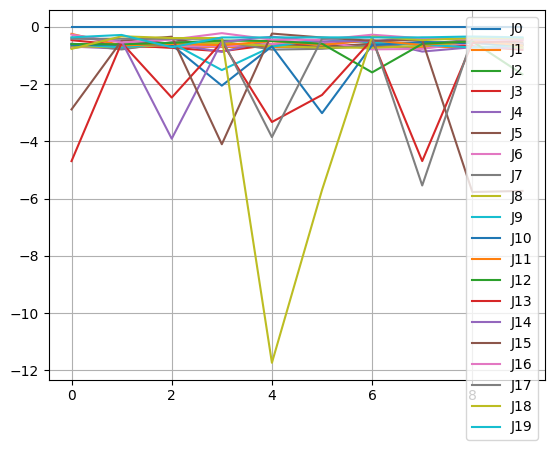

In [125]:
plt.figure()
for index, list in enumerate(J_list_list):
    if index<20:
        plt.plot(list, label='J'+str(index))
plt.legend()
plt.grid(True)
# plt.ylim((-5,0))

Text(0.5, 0, 'Prey [-]')

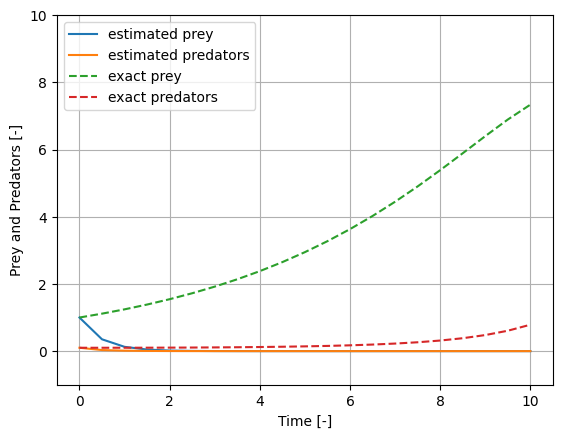

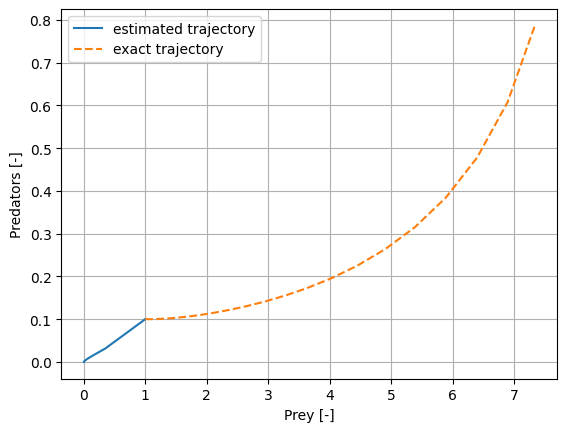

In [126]:
plt.figure()
plt.grid(True)
plt.plot(tt,x_hat[:,0], label='estimated prey')
plt.plot(tt,x_hat[:,1], label='estimated predators')
plt.plot(tt,x_ex[:,0], label='exact prey', linestyle='--')
plt.plot(tt,x_ex[:,1], label='exact predators', linestyle='--')
plt.legend()
plt.ylabel('Prey and Predators [-]')
plt.xlabel('Time [-]')
plt.ylim((-1,10))

plt.figure()
plt.grid(True)
plt.plot(x_hat[:,0],x_hat[:,1], label='estimated trajectory')
plt.plot(x_ex[:,0],x_ex[:,1], label='exact trajectory', linestyle='--')
plt.legend()
plt.ylabel('Predators [-]')
plt.xlabel('Prey [-]')